In [ ]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import shutil
import os
import cmdstanpy

from MarkovSeqGenerator import *
from hmmlearn.hmm import GaussianHMM
from scipy.stats import multinomial
from typing import List
from cmdstanpy import cmdstan_path, CmdStanModel

cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.30.1
Install directory: /root/.cmdstan
CmdStan version 2.30.1 already installed


True

In [ ]:
p = np.array([[0.6, 0.2, 0.2],
        [0.01, 0.9, 0.09],
        [0.1, 0.1, 0.8]])

mus = [10, 1, -10]
sigmas = [15, 5, 12]

obs, real_mu = get_seq(p, mus, sigmas, length = 300)

obs_train = np.expand_dims(np.array(obs[:-1]), -1)
obs_test = obs[-1]

For the test data, the true mean of three different states are set to be 10, 1, -10. The true sigmas of states are set to be large.

HMM-Learn is a well know package for the general use of Hidden markov model. However, since it's trained by the EM algortihm, it could be complicated to modify the model if we desire more complex structures inside between the observations and states.

Benefits of hmm learn:

1. Fast training.
2. Easy to use.

Disadvantages of hmm learn:

1. Sometimes lost track when sigma is large
2. Only provide a single number about the estimation instead of a range.

In [ ]:
model = GaussianHMM(n_components = 3, n_iter = 2000, tol = 1e-7)
model.fit(obs_train)
model.means_

array([[ 0.93560052],
       [-9.77170792],
       [17.90191369]])

If use hmm learn, the mus are estimated to be 0, -9, 17 which is fairly close.

Another way is to use stan's MCMC to get the estimations

Benefits of using stan:

1. Very flexible. You could assign the distribution to be any kind. For example, at time t, one observation from gaussian distribution and another from poisson distribution.

2. Gives a range of possible value.

Disadvantages:

1. Training coul take hours.
2. There are label switching problems. Hard to monitor the convergence.

In [ ]:
stan_data = {'N' : len(obs_train),
        'Z' : 3,
        'y' : obs_train.squeeze().tolist()}

with open("stan_data.json", "w") as write_file:
    json.dump(stan_data, write_file, indent=4)

In [ ]:
num_chains = 4
iter = 5000

model = CmdStanModel(stan_file = "Gaussian_HMM.stan")

fit = model.sample(chains = num_chains,
           parallel_chains = num_chains,
           data='stan_data.json',
           iter_warmup = iter,
           iter_sampling = iter,
           adapt_delta = 0.9995)

In [ ]:
result = fit.summary(percentiles = (5, 95))
result

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.30.1/bin/stansummary --percentiles= 5,95 --sig_figs=6 --csv_filename=/tmp/tmpqpcmo9wk/stansummary-Gaussian_HMM-93zzdx2n.csv /tmp/tmpqpcmo9wk/Gaussian_HMMl22iemni/Gaussian_HMM-20220829035835_1.csv /tmp/tmpqpcmo9wk/Gaussian_HMMl22iemni/Gaussian_HMM-20220829035835_2.csv /tmp/tmpqpcmo9wk/Gaussian_HMMl22iemni/Gaussian_HMM-20220829035835_3.csv /tmp/tmpqpcmo9wk/Gaussian_HMMl22iemni/Gaussian_HMM-20220829035835_4.csv
cwd: None


,Mean,MCSE,StdDev,5%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
lp__,-1060.070000,0.039477,3.065710,-1065.670000,-1055.690000,6030.73000,2.547650,1.000110
mu[1],0.933501,0.003189,0.402830,0.277414,1.587320,15952.20000,6.738900,1.000110
mu[2],4.319410,10.327600,15.071100,-12.606900,25.684200,2.12956,0.000900,3.827740
mu[3],4.286160,10.338400,15.080600,-12.741600,25.726900,2.12780,0.000899,3.851810
sigma[1],5.091250,0.002665,0.323374,4.576200,5.639630,14728.40000,6.221930,0.999941
...,...,...,...,...,...,...,...,...
y_last_prob[2],0.194754,0.080432,0.117882,0.063328,0.361442,2.14799,0.000907,3.596590
y_last_prob[3],0.195094,0.080478,0.117956,0.063336,0.362442,2.14828,0.000908,3.598980
y_last,1.586700,0.060580,0.795870,1.000000,3.000000,172.59310,0.072910,1.012140


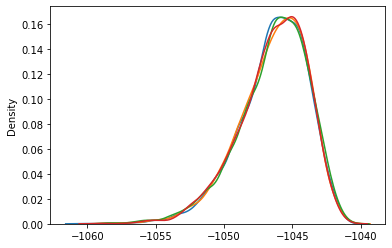

In [ ]:
forward_logp = np.split(fit.stan_variable('forward_logp'), num_chains)

for i in range(num_chains):

  sns.kdeplot(forward_logp[i])

In [ ]:
result.loc['x_hat']

Mean          -0.90092
MCSE           0.08132
StdDev        11.64445
5%           -20.95260
95%           15.37390
N_Eff      20505.72507
N_Eff/s        8.66252
R_hat          1.00021
Name: x_hat, dtype: float64

In [ ]:
obs_test

-3.5740953356772023

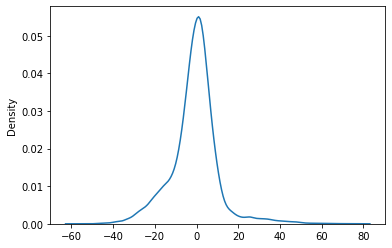

In [ ]:
sns.kdeplot(fit.stan_variable('x_hat'))

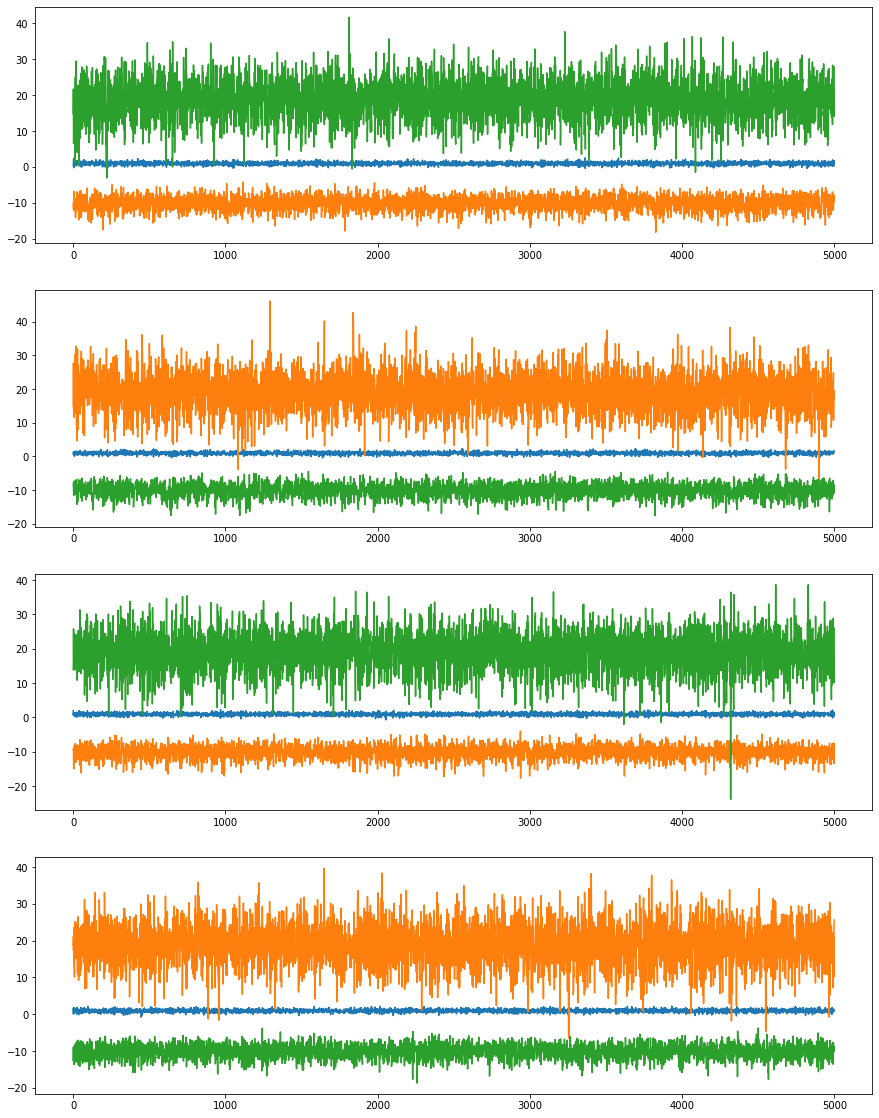

In [ ]:
fig, ax = plt.subplots(num_chains)

fig.set_figwidth(15)
fig.set_figheight(num_chains * 5)

data = np.split(fit.stan_variable('mu'), num_chains)

for i in range(num_chains):
  ax[i].plot(data[i])
plt.subplots_adjust()